# Imports

In [52]:
import os
import os.path as osp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
import seaborn as sns

from utils.config import config

**Disclaimer:**

Used implementations are borrowed from [cs231n](http://cs231n.stanford.edu/) and [dlcourse.ai](https://dlcourse.ai/) homeworks. Here backward and forward passes are distinguished, and layers are implemented so that they eventually allow to use chain rule. The abstractions are debugged so that the results coincide with the functions provided during labs.

# Implementation of sigmoid and binary cross-entropy and its grads

In [2]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    s = 1. / (1. + np.exp(-z))
    
    return s

def bcc(probas, y_true):
    assert probas.shape == y_true.shape, f"Probas shape {probas.shape}, y true shape {y_true.shape}"
    return - np.mean(y_true * np.log(probas) + (1 - y_true) * np.log(1 - probas))

def bcc_with_sigmoid(logits, y):
    
    # Forward part
    probas = sigmoid(logits)
    loss = bcc(probas, y)
    
    # Backward part
    grad = - 1. / y.shape[0] * (y - probas)
    
    return loss, grad

# Implementation of layers

In [3]:
class Param:
    """
    Trainable parameter of the model
    Captures both parameter value and the gradient
    """

    def __init__(self, value):
        self.value = value
        self.grad = np.zeros_like(value)

        
class FullyConnectedLayer:
    def __init__(self, n_input, n_output, W=None, B=None, init="xavier", random_seed=24):
        np.random.seed(random_seed)
        if init == "xavier":
            self.W = Param(np.sqrt(2/(n_input*10)) * np.random.randn(n_input, n_output))
            self.B = Param(np.sqrt(2/(n_input*10)) * np.random.randn(1, n_output))
        elif init == "zeros":
            self.W = Param(np.zeros((n_input, n_output)))
            self.B = Param(np.zeros((1, n_output)))
        if W is not None:
            self.W.value = W
        if B is not None:
            self.B.value = B
        self.X = None

    def forward(self, X):
        self.X = X
        out = np.dot(X, self.W.value) + self.B.value
        return out

    def backward(self, d_out):
        """
        Backward pass
        Computes gradient with respect to input and
        accumulates gradients within self.W and self.B

        Arguments:
        d_out, np array (batch_size, n_output) - gradient
           of loss function with respect to output

        Returns:
        d_result: np array (batch_size, n_input) - gradient
          with respect to input
        """

        d_result = np.dot(self.W.value, d_out.T).T
        self.W.grad = np.dot(self.X.T, d_out)
        self.B.grad = np.sum(d_out, axis=0, keepdims=True)

        return d_result

    def params(self):
        return {"W": self.W, "B": self.B}
    

class LogReg:
    def __init__(self, n_input, n_output=1, W=None, B=None):
        self.layer = FullyConnectedLayer(n_input, n_output, W=W, B=B)

    def forward_train(self, X, y):
        """
        Computes total loss and updates parameter gradients
        on a batch of training examples

        Arguments:
        X, np array (batch_size, input_features) - input data
        y, np array of int (batch_size) - classes
        """
        # Zero gradients
        params = self.params()
        for param in params.keys():
            params[param].grad = np.zeros_like(params[param].grad)
        
        # Forward pass
        out = self.layer.forward(X)
        
        # Compute loss
        loss, grad = bcc_with_sigmoid(out, y)
        
        # Backward pass
        grad_out = self.layer.backward(grad)

        return loss
    
    def forward_eval(self, X):
        out = self.layer.forward(X)
        out = sigmoid(out)
        return out
        
    def params(self):
        return self.layer.params()

### Check that the values in the example are the same as in the example in original notebook

In [4]:
w, b, X, Y = np.array([[1.],[-1.]]), np.asarray([4.]), np.array([[1.,5.,-1.],[10.,0.,-3.2]]).T, np.array([[0,1,1]]).T

print(w.shape, b.shape, X.shape, Y.shape)

lg = LogReg(2, W=w, B=b)
loss = lg.forward_train(X, Y)
loss, lg.layer.W.grad, lg.layer.B.grad

(2, 1) (1,) (3, 2) (3, 1)


(0.002955374934226532,
 array([[0.0027004 ],
        [0.02446984]]),
 array([[0.00151471]]))

# Optimizers

In [5]:
class SGD:
    def __init__(self, learning_rate, params=None):
        self.lr = learning_rate
    
    def update(self, w, d_w, param_name=None):
        return w - d_w * self.lr
    
class Adam:
    def __init__(self, learning_rate, params, beta_1=0.9, beta_2=0.999, eps=1e-8):
        self.lr = learning_rate
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.eps = eps

        self.m_t = {}
        self.v_t = {}
        self.t = {}
        self.beta_1_t = {}
        self.beta_2_t = {}
        for param_name, param in params.items():
            self.m_t[param_name] = np.zeros_like(param)
            self.v_t[param_name] = np.zeros_like(param)
            self.t[param_name] = 0
            self.beta_1_t[param_name] = self.beta_1
            self.beta_2_t[param_name] = self.beta_2
    
    def update(self, w, d_w, param_name):
        self.t[param_name] += 1
        self.m_t[param_name] = self.beta_1 * self.m_t[param_name] + (1 - self.beta_1) * d_w
        self.v_t[param_name] = self.beta_2 * self.v_t[param_name] + (1 - self.beta_2) * (d_w ** 2)
        self.beta_1_t[param_name] *= self.beta_1
        self.beta_2_t[param_name] *= self.beta_2
        m_hat_t = self.m_t[param_name] / (1 - self.beta_1_t[param_name])
        v_hat_t = self.v_t[param_name] / (1 - self.beta_2_t[param_name])
        return w - self.lr * m_hat_t / (np.sqrt(v_hat_t) + self.eps)

# Train function

In [25]:
def step(batch_X, batch_y, model, optim):
    # Cost and gradient calculation 
    loss = model.forward_train(batch_X, batch_y)

    # Update params based on gradients
    for param_name, param in model.params().items():
        param.value = optim.update(param.value, param.grad, param_name)
    
    return loss


def optimize(w, b, X, Y, num_iterations, learning_rate, algorithm_name="SGD", batched=False, batch_size=16, print_cost=False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array 
    b -- bias, a scalar
    X -- data 
    Y -- true "label" vector (containing 0 and 1), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    """
    np.random.seed(24)
    
    model = LogReg(X.shape[1], W=w, B=b)
    
    assert algorithm_name in {"SGD", "Adam"}
    if algorithm_name == "SGD":
        optim = SGD(learning_rate=learning_rate)
    elif algorithm_name == "Adam":
        optim = Adam(learning_rate=learning_rate, params=model.params())
    
    costs = []
    
    for i in range(num_iterations):
        if batched:
            shuffled_indices = np.arange(X.shape[0])
            np.random.shuffle(shuffled_indices)
            sections = np.arange(batch_size, X.shape[0], batch_size)
            batched_indices = np.array_split(shuffled_indices, sections)
            running_loss = 0
            
            for batch_ids in batched_indices:
                batch_X = X[batch_ids].copy()
                batch_y = Y[batch_ids].copy()
                
                loss = step(batch_X, batch_y, model, optim)
                running_loss += loss
            loss = running_loss / len(batched_indices)
        else:
            loss = step(X, Y, model, optim)
        
        # Record the costs
        if i % 100 == 0:
            costs.append(loss)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, loss))
    
    return model, costs

### Make sure that we did everything right

In [7]:
model, costs = optimize(w, b, X, Y, num_iterations=1000, learning_rate=0.005, print_cost=True)

print(f"w = {model.layer.W.value}")
print(f"b = {model.layer.B.value}")
print(f"dw = {model.layer.W.grad}")
print(f"db = {model.layer.B.grad}")

Cost after iteration 0: 0.002955
Cost after iteration 100: 0.002683
Cost after iteration 200: 0.002461
Cost after iteration 300: 0.002278
Cost after iteration 400: 0.002124
Cost after iteration 500: 0.001991
Cost after iteration 600: 0.001877
Cost after iteration 700: 0.001777
Cost after iteration 800: 0.001689
Cost after iteration 900: 0.001611
w = [[ 0.99092423]
 [-1.08149946]]
b = [[3.99591156]]
dw = [[0.00128065]
 [0.01144573]]
db = [[0.00041775]]


In [13]:
model, costs = optimize(w, b, X, Y, num_iterations=1000, algorithm_name="Adam", learning_rate=0.005, print_cost=True)

print(f"w = {model.layer.W.value}")
print(f"b = {model.layer.B.value}")
print(f"dw = {model.layer.W.grad}")
print(f"db = {model.layer.B.grad}")

Cost after iteration 0: 0.824838
Cost after iteration 100: 0.442080
Cost after iteration 200: 0.300160
Cost after iteration 300: 0.221214
Cost after iteration 400: 0.169239
Cost after iteration 500: 0.132932
Cost after iteration 600: 0.106732
Cost after iteration 700: 0.087335
Cost after iteration 800: 0.072642
Cost after iteration 900: 0.061280
w = [[-2.04085963]
 [ 1.08084003]]
b = [[-1.59008724]]
dw = [[ 0.05703178]
 [-0.00250016]]
db = [[0.00852372]]


# Predict function

In [8]:
def predict(model, X, w=None, b=None):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array 
    b -- bias, a scalar
    X -- data 
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    if (w is not None) and (b is not None):
        model = LogReg(X.shape[1], W=w, B=b)
        
    probas = model.forward_eval(X)
    Y_prediction = (probas > 0.5).astype(int)
    
    return Y_prediction

### Again make sure everything conicides wtih the code in notebook from labs

In [9]:
w = np.array([[0.1124579],[0.23106775]])
b = np.asarray([-0.3])
X = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]]).T
print ("predictions = " + str(predict(model, X, w=w, b=b)))

predictions = [[1]
 [1]
 [0]]


# Train and eval function

In [21]:
def train_eval(
    X_train, 
    Y_train, 
    X_test, 
    Y_test, 
    init="zeros", 
    algorithm_name="SGD", 
    batched=False, 
    batch_size=16, 
    num_iterations=2000, 
    learning_rate=0.5, 
    print_cost=False):
    """
    Builds the logistic regression model by calling the function we've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array 
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array 
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    model = LogReg(X_train.shape[1])

    # Gradient descent
    model, costs = optimize(
        w=None, 
        b=None, 
        X=X_train, 
        Y=Y_train, 
        num_iterations=num_iterations, 
        learning_rate=learning_rate, 
        algorithm_name=algorithm_name, 
        batched=batched, 
        batch_size=batch_size, 
        print_cost=print_cost)
    
    # Predict test/train set examples
    Y_prediction_test = predict(model, X_test)
    Y_prediction_train = predict(model, X_train)

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

# Load data

In [22]:
df_path = osp.join(config.data_dir, "task1", "bioresponse.csv")
df = pd.read_csv(df_path)

df_train, df_test = train_test_split(df, test_size=0.25, random_state=24, stratify=df["Activity"])

X_train = df_train.drop(columns="Activity").values
Y_train = df_train[["Activity"]].values
X_test = df_test.drop(columns="Activity").values
Y_test = df_test[["Activity"]].values

# (1) Apply the logistic regression method to predict the biological response of a molecule 

**Spoiler**: with Xavier initialization and 2000 of iterations test accuracy is about **0.688**.

In [23]:
d = train_eval(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.001, print_cost=True)

Cost after iteration 0: 0.700621
Cost after iteration 100: 0.677810
Cost after iteration 200: 0.670104
Cost after iteration 300: 0.663753
Cost after iteration 400: 0.657907
Cost after iteration 500: 0.652462
Cost after iteration 600: 0.647367
Cost after iteration 700: 0.642585
Cost after iteration 800: 0.638081
Cost after iteration 900: 0.633828
Cost after iteration 1000: 0.629803
Cost after iteration 1100: 0.625985
Cost after iteration 1200: 0.622356
Cost after iteration 1300: 0.618899
Cost after iteration 1400: 0.615601
Cost after iteration 1500: 0.612450
Cost after iteration 1600: 0.609433
Cost after iteration 1700: 0.606542
Cost after iteration 1800: 0.603766
Cost after iteration 1900: 0.601099
train accuracy: 71.91610380376821 %
test accuracy: 68.7633262260128 %


# (2) Modify optimize() function to implement the stochastic gradient descent (SGD) method. Apply it to solve the problem from p.1.

**Spoiler**: Xavier initialization + batched training with batch size 128 => test accuracy **0.766**.

In [27]:
d = train_eval(X_train, Y_train, X_test, Y_test, batched=True, batch_size=128, num_iterations=2000, learning_rate=0.001, print_cost=True)

Cost after iteration 0: 0.696034
Cost after iteration 100: 0.593545
Cost after iteration 200: 0.555732
Cost after iteration 300: 0.532517
Cost after iteration 400: 0.516360
Cost after iteration 500: 0.504276
Cost after iteration 600: 0.494598
Cost after iteration 700: 0.486751
Cost after iteration 800: 0.480230
Cost after iteration 900: 0.474528
Cost after iteration 1000: 0.469642
Cost after iteration 1100: 0.465317
Cost after iteration 1200: 0.461361
Cost after iteration 1300: 0.457831
Cost after iteration 1400: 0.454738
Cost after iteration 1500: 0.451604
Cost after iteration 1600: 0.448915
Cost after iteration 1700: 0.446261
Cost after iteration 1800: 0.443850
Cost after iteration 1900: 0.441709
train accuracy: 80.59011731247779 %
test accuracy: 76.65245202558636 %


# (3) For two modifications of gradient descent (pp. 1 and 2), plot the learning curves (dependence of the value of the loss function on the iteration number), apply models with different values of the learning rate (at least 5 different learning rates). How does it affect the accuracy of the model?

In [29]:
data = {}

for lr in [1e-4, 5e-4, 1e-3, 5e-3, 1e-2]:
    for batched in [False, True]:
        print(f"\nLearning rate: {lr:.4f}, batched: {batched}")
        d = train_eval(X_train, Y_train, X_test, Y_test, batched=batched, batch_size=128, num_iterations=2000, learning_rate=lr, print_cost=True)
        data[f"{lr:.4f} batched {batched}"] = d


Learning rate: 0.0001, batched: False
Cost after iteration 0: 0.700621
Cost after iteration 100: 0.695800
Cost after iteration 200: 0.691990
Cost after iteration 300: 0.688944
Cost after iteration 400: 0.686473
Cost after iteration 500: 0.684436
Cost after iteration 600: 0.682726
Cost after iteration 700: 0.681263
Cost after iteration 800: 0.679988
Cost after iteration 900: 0.678854
Cost after iteration 1000: 0.677829
Cost after iteration 1100: 0.676886
Cost after iteration 1200: 0.676007
Cost after iteration 1300: 0.675178
Cost after iteration 1400: 0.674387
Cost after iteration 1500: 0.673626
Cost after iteration 1600: 0.672890
Cost after iteration 1700: 0.672173
Cost after iteration 1800: 0.671472
Cost after iteration 1900: 0.670785
train accuracy: 58.478492712406684 %
test accuracy: 57.24946695095949 %

Learning rate: 0.0001, batched: True
Cost after iteration 0: 0.700079
Cost after iteration 100: 0.668731
Cost after iteration 200: 0.655653
Cost after iteration 300: 0.644420
Cost 

Stochasticity helps to fit more accurate models.

With growth of learning rate learning curves become less smooth.

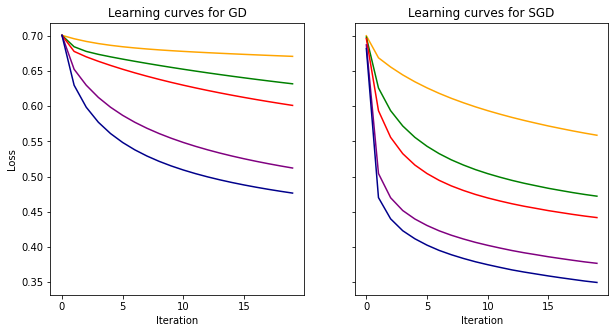

In [46]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5), sharey=True, sharex=True)
for lr, color in zip([1e-4, 5e-4, 1e-3, 5e-3, 1e-2], ["orange", "green", "red", "purple", "darkblue"]):
    for idx, batched in enumerate([False, True]):
        cost = data[f"{lr:.4f} batched {batched}"]["costs"]
        ax[idx].plot(np.arange(len(cost)), cost, color=color, label=f"lr {lr:.4f}")
        
ax[0].set_title("Learning curves for GD")
ax[1].set_title("Learning curves for SGD")
ax[0].set_ylabel("Loss")
ax[0].set_xlabel("Iteration")
ax[1].set_xlabel("Iteration")
plt.show()

With increase of learning rate the train accuracy always increases. The test accuracy also increases for the case of simple gradient descent without stochasticity, but in the case of SGD the model starts overfitting when learning rate is equal to 0.01 - the train accuracy is higher than for lr=0.005, but the test accuracy is lower.

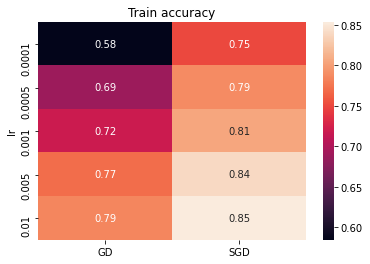

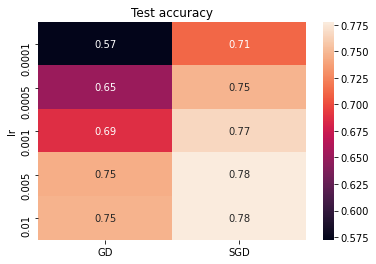

In [57]:
df = pd.DataFrame({
    "GD": [metrics.accuracy_score(Y_train, data[f"{lr:.4f} batched False"]["Y_prediction_train"]) for lr in [1e-4, 5e-4, 1e-3, 5e-3, 1e-2]],
    "SGD": [metrics.accuracy_score(Y_train, data[f"{lr:.4f} batched True"]["Y_prediction_train"]) for lr in [1e-4, 5e-4, 1e-3, 5e-3, 1e-2]]
}, index=pd.Index([1e-4, 5e-4, 1e-3, 5e-3, 1e-2], name="lr"))
sns.heatmap(df, annot=True)
plt.title("Train accuracy")
plt.show();

df = pd.DataFrame({
    "GD": [metrics.accuracy_score(Y_test, data[f"{lr:.4f} batched False"]["Y_prediction_test"]) for lr in [1e-4, 5e-4, 1e-3, 5e-3, 1e-2]],
    "SGD": [metrics.accuracy_score(Y_test, data[f"{lr:.4f} batched True"]["Y_prediction_test"]) for lr in [1e-4, 5e-4, 1e-3, 5e-3, 1e-2]]
}, index=pd.Index([1e-4, 5e-4, 1e-3, 5e-3, 1e-2], name="lr"))
sns.heatmap(df, annot=True)
plt.title("Test accuracy")
plt.show();

# (4) Implement the Adam optimization method using the numpy library and compare the accuracy of the model fitted with it with the models trained by the classic GD and SGD algorithms.

In [61]:
for lr in [1e-4, 5e-4, 1e-3, 5e-3, 1e-2]:
    print(f"\nLearning rate: {lr:.4f}, Adam")
    d = train_eval(X_train, Y_train, X_test, Y_test, algorithm_name="Adam", batched=True, batch_size=128, num_iterations=2000, learning_rate=lr, print_cost=True)
    data[f"{lr:.4f} Adam"] = d


Learning rate: 0.0001, Adam
Cost after iteration 0: 0.692789
Cost after iteration 100: 0.500022
Cost after iteration 200: 0.449071
Cost after iteration 300: 0.419499
Cost after iteration 400: 0.399256
Cost after iteration 500: 0.384460
Cost after iteration 600: 0.372643
Cost after iteration 700: 0.362935
Cost after iteration 800: 0.354786
Cost after iteration 900: 0.347599
Cost after iteration 1000: 0.341431
Cost after iteration 1100: 0.335840
Cost after iteration 1200: 0.330696
Cost after iteration 1300: 0.325925
Cost after iteration 1400: 0.321786
Cost after iteration 1500: 0.317665
Cost after iteration 1600: 0.314066
Cost after iteration 1700: 0.310449
Cost after iteration 1800: 0.307163
Cost after iteration 1900: 0.304235
train accuracy: 87.34447209384999 %
test accuracy: 77.50533049040511 %

Learning rate: 0.0005, Adam
Cost after iteration 0: 0.684324
Cost after iteration 100: 0.391595
Cost after iteration 200: 0.348470
Cost after iteration 300: 0.323624
Cost after iteration 400:

/home/glyc/.virtualenvs/algo/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/home/glyc/.virtualenvs/algo/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in multiply


Cost after iteration 1100: nan
Cost after iteration 1200: nan
Cost after iteration 1300: nan
Cost after iteration 1400: nan
Cost after iteration 1500: nan
Cost after iteration 1600: nan
Cost after iteration 1700: nan
Cost after iteration 1800: nan
Cost after iteration 1900: nan
train accuracy: 93.28119445431923 %
test accuracy: 75.15991471215352 %

Learning rate: 0.0050, Adam
Cost after iteration 0: 0.651977
Cost after iteration 100: 0.272033
Cost after iteration 200: 0.234483
Cost after iteration 300: nan
Cost after iteration 400: nan
Cost after iteration 500: nan
Cost after iteration 600: nan
Cost after iteration 700: nan
Cost after iteration 800: nan
Cost after iteration 900: nan
Cost after iteration 1000: nan
Cost after iteration 1100: nan
Cost after iteration 1200: nan
Cost after iteration 1300: nan
Cost after iteration 1400: nan
Cost after iteration 1500: nan
Cost after iteration 1600: nan
Cost after iteration 1700: nan
Cost after iteration 1800: nan
Cost after iteration 1900: na

Oh, great, Adam cannot be learned using too high learning rates because of gradient instability.

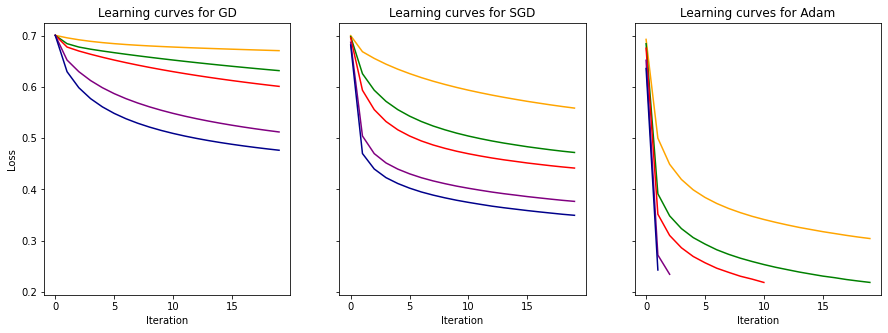

In [63]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 5), sharey=True, sharex=True)
for lr, color in zip([1e-4, 5e-4, 1e-3, 5e-3, 1e-2], ["orange", "green", "red", "purple", "darkblue"]):
    for idx, optim in enumerate(["batched False", "batched True", "Adam"]):
        cost = data[f"{lr:.4f} {optim}"]["costs"]
        ax[idx].plot(np.arange(len(cost)), cost, color=color, label=f"lr {lr:.4f}")
        
ax[0].set_title("Learning curves for GD")
ax[1].set_title("Learning curves for SGD")
ax[2].set_title("Learning curves for Adam")
ax[0].set_ylabel("Loss")
ax[0].set_xlabel("Iteration")
ax[1].set_xlabel("Iteration")
ax[2].set_xlabel("Iteration")
plt.show()

Adam overfits the data even more fast than SGD - it reaches the maximum of test accuracy at learning rate 1e-4.

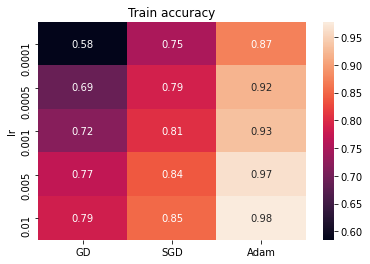

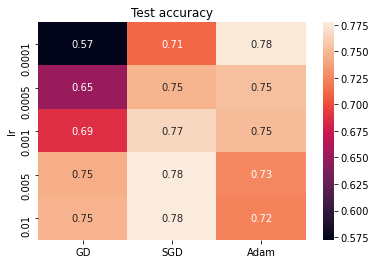

In [64]:
df = pd.DataFrame({
    "GD": [metrics.accuracy_score(Y_train, data[f"{lr:.4f} batched False"]["Y_prediction_train"]) for lr in [1e-4, 5e-4, 1e-3, 5e-3, 1e-2]],
    "SGD": [metrics.accuracy_score(Y_train, data[f"{lr:.4f} batched True"]["Y_prediction_train"]) for lr in [1e-4, 5e-4, 1e-3, 5e-3, 1e-2]],
    "Adam": [metrics.accuracy_score(Y_train, data[f"{lr:.4f} Adam"]["Y_prediction_train"]) for lr in [1e-4, 5e-4, 1e-3, 5e-3, 1e-2]],
}, index=pd.Index([1e-4, 5e-4, 1e-3, 5e-3, 1e-2], name="lr"))
sns.heatmap(df, annot=True)
plt.title("Train accuracy")
plt.show();

df = pd.DataFrame({
    "GD": [metrics.accuracy_score(Y_test, data[f"{lr:.4f} batched False"]["Y_prediction_test"]) for lr in [1e-4, 5e-4, 1e-3, 5e-3, 1e-2]],
    "SGD": [metrics.accuracy_score(Y_test, data[f"{lr:.4f} batched True"]["Y_prediction_test"]) for lr in [1e-4, 5e-4, 1e-3, 5e-3, 1e-2]],
    "Adam": [metrics.accuracy_score(Y_test, data[f"{lr:.4f} Adam"]["Y_prediction_test"]) for lr in [1e-4, 5e-4, 1e-3, 5e-3, 1e-2]],
}, index=pd.Index([1e-4, 5e-4, 1e-3, 5e-3, 1e-2], name="lr"))
sns.heatmap(df, annot=True)
plt.title("Test accuracy")
plt.show();